# Coding Project
## Ph 549: Physics of Biological Systems

**Author**: Vedant Prakash Shenoy

The microtubule is represented by an array of 0s and 1s. The 0 corresponds to the GDP<sup>-</sup> and 1 corresponds to GTP<sup>+</sup>. There are 3 processes which determine growth of microtubule molecules.

$$|\cdots+\rangle \overset{\lambda}{\longrightarrow} |\cdots++\rangle $$
$$|\cdots-\rangle \overset{p\lambda}{\longrightarrow} |\cdots-+\rangle $$
$$|\cdots+\cdots\rangle \overset{1}{\longrightarrow} |\cdots-\cdots\rangle $$
$$|\cdots-\rangle \overset{\mu}{\longrightarrow} |\cdots\rangle $$

3 parameters control the growth of the microtubules.

---

We will use `numpy` for vectorized array operations (and later for data serialization), `numba` for JIT compilation (this speeds up the program significantly; for example, (a previous version of) the function to make the final image took ~50 minutes without JIT compiling, and ~7 minutes when JIT compilation was introduced just for the `microtubule_step` function)

`matplotlib` offers an easy plotting API

In [1]:
import numpy as np
from numba import njit
import matplotlib.pyplot as plt

The following imports are to implement multiprocessing which will be useful for Figure 6

In [2]:
from functools import partial
from multiprocessing import pool

Other imports required for Figure 6

In [3]:
import os
import matplotlib as mpl

Change some plotting defaults

In [4]:
plt.rcParams['font.size'] = 12

plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'

plt.rcParams['xtick.top'] = True
plt.rcParams['ytick.right'] = True

---

In [5]:
@njit
def transition_rates(chain, lam, p, mu):
    """Calculates transition rates for every possible transition given a chain"""
    k_attach = lam if chain[-1] else p*lam
    k_convert = np.ones(np.where(chain)[0].size)
    k_detach = mu if not chain[-1] else 0

    return np.append(np.append(k_attach, k_convert), k_detach)

In [6]:
@njit
def island_lens(chain):
    """Find lengths of GTP islands, i.e. 1s"""
    points_of_change = np.where(np.diff(chain))[0] + 1
    if chain[0]:
        points_of_change = np.append(0, points_of_change)
    if chain[-1]:
        points_of_change = np.append(points_of_change, chain.size)
    ilens = points_of_change.reshape(-1,2)
    ilens = ilens[:,1]-ilens[:,0]
    return ilens

In [7]:
@njit
def microtubule_step(chain, lam, p, mu):
    """Implement step in the BLK algorithm
    
    Returns the new chain and the time step
    """
    cum_rate = np.cumsum(transition_rates(chain, lam, p, mu))

    ind = np.searchsorted(cum_rate, np.random.random()*cum_rate[-1])
    dt = np.log(1/np.random.random())/cum_rate[-1]
    
    if ind==0:
        return np.append(chain, 1), dt
    elif ind==cum_rate.size-1:
        return chain[:-1], dt
    else:
        chain[np.where(chain==1)[0][ind-1]] = 0
        return chain, dt


In [8]:
class State:
    """Container for the state of the system at any point of time"""
    def __init__(self, lam, p, mu):
        """A microtubule system is defined by the 3 parameters"""
        self._chain = np.array([1])
        self._t = 0
        self.lam = lam
        self.p = p
        self.mu = mu
        
    @property
    def t(self):
        return self._t

    @property
    def chain(self):
        return self._chain
    
    @property
    def n(self):
        return len(self._chain)
    
    @property
    def capsize(self):
        """Returns the length of the GTP cap"""
        if self._chain[-1]==1:
            return self.islands()[-1]
        else:
            return 0
    
    def islands(self):
        """Returns the lengths of all the GTP islands"""
        return island_lens(self.chain)
        
    def step(self):
        """Implements one step in the BLK algorithm"""
        chain, dt = microtubule_step(self._chain, self.lam, self.p, self.mu)
        self._chain = chain
        self._t += dt

---

## Figure 1
Figure 1 shows the evolution of the length of the microtubule with time, with different values of $\lambda$. 

Mirroring the values from the paper, I have chosen $p=1$, $\mu=5$ and $\lambda = 1.4, 1.5, 1.6$

In [9]:
sp = State(1.4, 1, 5)

The initial run will take ~3-5 seconds, as the JIT compiler translates the Python code to low level machine code.

In [10]:
%%time
lens = [sp.n]
t = [sp.t]
while t[-1]<10000:
    sp.step()
    lens.append(sp.n)
    t.append(sp.t)
t = np.array(t)
lens = np.array(lens)

CPU times: user 2.17 s, sys: 18.8 ms, total: 2.19 s
Wall time: 2.19 s


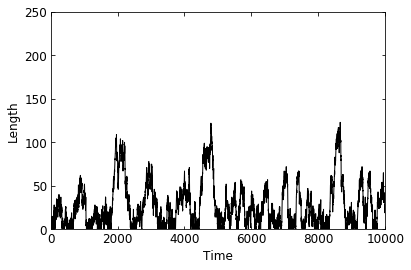

In [11]:
plt.plot(t, lens, color='k', lw=1)
plt.xlim(0,10000)
plt.ylim(0,250)
plt.yticks(np.linspace(plt.ylim()[0],plt.ylim()[1],6))
plt.xlabel("Time")
plt.ylabel("Length")
plt.savefig("plots/1a.pdf")

In [12]:
sp = State(1.5, 1, 5)

In [13]:
%%time
lens = [sp.n]
t = [sp.t]
while t[-1]<10000:
    sp.step()
    lens.append(sp.n)
    t.append(sp.t)
t = np.array(t)
lens = np.array(lens)

CPU times: user 150 ms, sys: 11.7 ms, total: 162 ms
Wall time: 161 ms


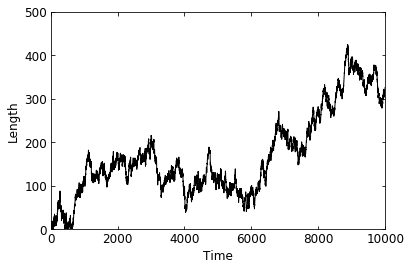

In [14]:
plt.plot(t, lens, color='k', lw=1)
plt.xlim(0,10000)
plt.ylim(0,500)
plt.yticks(np.linspace(plt.ylim()[0],plt.ylim()[1],6))
plt.xlabel("Time")
plt.ylabel("Length")
plt.savefig("plots/1b.pdf")

In [15]:
sp = State(1.6, 1, 5)

In [16]:
%%time
lens = [sp.n]
t = [sp.t]
while t[-1]<10000:
    sp.step()
    lens.append(sp.n)
    t.append(sp.t)
t = np.array(t)
lens = np.array(lens)

CPU times: user 209 ms, sys: 3.87 ms, total: 213 ms
Wall time: 212 ms


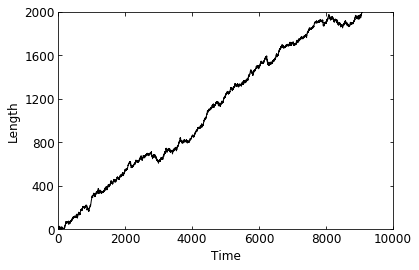

In [17]:
plt.plot(t, lens, color='k', lw=1)
plt.xlim(0,10000)
plt.ylim(0,2000)
plt.yticks(np.linspace(plt.ylim()[0],plt.ylim()[1],6))
plt.xlabel("Time")
plt.ylabel("Length")
plt.savefig("plots/1c.pdf")

---

## Figures 4 and 5
Figure 4 shows the distribution of the length of the GTP cap of the microtubule, and Figure 5 shows the distribution of the length of the GTP islands in the microtubule

In [18]:
@np.vectorize
def prob(k, lam):
    """Probability of GTP capsize being k"""
    return 1/np.product((lam+1+k-np.arange(k+1))/lam)/lam*(k+1)

def iprob(k, lam):
    """Probability of GTP island length being k"""
    return 4/(k*(k+1)*(k+2))

In [19]:
print(f"Sum of Capsize Probabilites: {prob(np.arange(0,100), 100).sum():.5f}")

Sum of Capsize Probabilites: 1.00000


In [20]:
print(f"Sum of Island Probabilites: {iprob(np.arange(1,1000000), 100).sum():.5f}")

Sum of Island Probabilites: 1.00000


In [21]:
sp = State(100,1,0)

In [22]:
%%time
lens = [sp.n]
t = [sp.t]
cs = [sp.capsize]
isl = [sp.islands()]
# while t[-1]<10000:
for i in range(50000):
# while lens[-1]<1e5:
    sp.step()
    lens.append(sp.n)
    t.append(sp.t)
    cs.append(sp.capsize)
    if sp.capsize == 0:
        isl.append(sp.islands())
    else:
        isl.append(sp.islands()[:-1])

CPU times: user 5.79 s, sys: 11.7 ms, total: 5.8 s
Wall time: 5.8 s


In [23]:
cs = np.array(cs)

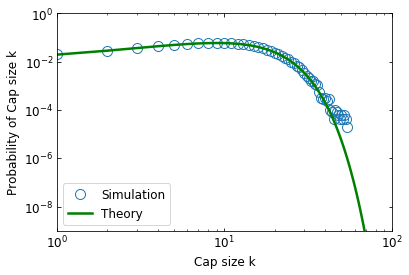

In [24]:
# plt.figure(figsize=(6,4))
bins, counts = np.unique(cs[cs>0], return_counts=True)
plt.plot(bins, counts/counts.sum(), ls='', marker='o', mfc='none', mew=1, markersize=10, label='Simulation')
plt.yscale('log')
plt.xscale("log")
plt.plot((np.arange(1,100)), prob(np.arange(1,100),100), color='g', lw=2.5, label='Theory')
plt.ylim(10**-9,1)
plt.yticks(10**np.linspace(-8,0,5))
plt.xlim(1,100)
plt.xlabel("Cap size k")
plt.ylabel("Probability of Cap size k")
plt.legend()
plt.savefig("plots/4.pdf")

In [25]:
il = np.concatenate(isl)

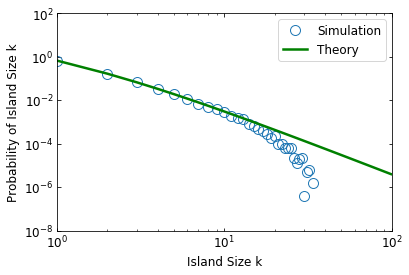

In [26]:
# counts, bins = np.histogram(il, bins=(np.arange(1,100)-0.5));
# bins = 0.5*(bins[1:] + bins[:-1])
bins, counts = np.unique(il, return_counts=True)
plt.plot(bins, counts/counts.sum(), ls='', marker='o', mfc='none', mew=1, markersize=10, label='Simulation')
plt.yscale('log')
plt.xscale('log')
plt.plot(np.arange(1,100), iprob(np.arange(1,100),100), color='g', lw=2.5, label="Theory")
plt.ylim(10**-8,100)
plt.xlim(1,100)
plt.xlabel("Island Size k")
plt.ylabel("Probability of Island Size k")
plt.legend()
plt.savefig("plots/5.pdf")

In [27]:
def check_bound_chains(mu, lam, p):
    """Checks if a chain is bounded
    
    Unbounded chain is one which does not
    exceed length 5000 after 100,000 steps.
    This is a very crude approximation, and
    in general the bounding value of mu is
    underestimated.
    """
    sp = State(lam, p, mu)
    for i in range(100_000):
        sp.step()
        if sp.n>5000:
            return False
    return True

In [28]:
mu_array = np.round(np.linspace(0,10,101),2)

In [29]:
lam_array = {0.1 : np.round(np.linspace(0,4,51),2)[1:],
             1 : np.round(np.linspace(0,2,51),2)[1:]}

Run for p = 0.1

In [30]:
p = 0.1

In [31]:
%%time
bounded = []
for prog, lam in enumerate(lam_array[p]):
    par_save = partial(check_bound_chains, lam=lam, p=p)
    with pool.Pool(4) as po:
        res = po.map(par_save, mu_array)
    print(f"Progress: {prog/lam_array[p].size}")
    bounded.append(res)
bounded = np.array(bounded)
np.save(f'chains/bound_{p}', bounded)

Progress: 0.0
Progress: 0.02
Progress: 0.04
Progress: 0.06
Progress: 0.08
Progress: 0.1
Progress: 0.12
Progress: 0.14
Progress: 0.16
Progress: 0.18
Progress: 0.2
Progress: 0.22
Progress: 0.24
Progress: 0.26
Progress: 0.28
Progress: 0.3
Progress: 0.32
Progress: 0.34
Progress: 0.36
Progress: 0.38
Progress: 0.4
Progress: 0.42
Progress: 0.44
Progress: 0.46
Progress: 0.48
Progress: 0.5
Progress: 0.52
Progress: 0.54
Progress: 0.56
Progress: 0.58
Progress: 0.6
Progress: 0.62
Progress: 0.64
Progress: 0.66
Progress: 0.68
Progress: 0.7
Progress: 0.72
Progress: 0.74
Progress: 0.76
Progress: 0.78
Progress: 0.8
Progress: 0.82
Progress: 0.84
Progress: 0.86
Progress: 0.88
Progress: 0.9
Progress: 0.92
Progress: 0.94
Progress: 0.96
Progress: 0.98
CPU times: user 786 ms, sys: 1.19 s, total: 1.97 s
Wall time: 11min 37s


Run for p = 1

In [32]:
p = 1

In [33]:
%%time
bounded = []
for prog, lam in enumerate(lam_array[p]):
    par_save = partial(check_bound_chains, lam=lam, p=p)
    with pool.Pool(4) as po:
        res = po.map(par_save, mu_array)
    print(f"Progress: {prog/lam_array[p].size}")
    bounded.append(res)
bounded = np.array(bounded)
np.save(f'chains/bound_{p}', bounded)

Progress: 0.0
Progress: 0.02
Progress: 0.04
Progress: 0.06
Progress: 0.08
Progress: 0.1
Progress: 0.12
Progress: 0.14
Progress: 0.16
Progress: 0.18
Progress: 0.2
Progress: 0.22
Progress: 0.24
Progress: 0.26
Progress: 0.28
Progress: 0.3
Progress: 0.32
Progress: 0.34
Progress: 0.36
Progress: 0.38
Progress: 0.4
Progress: 0.42
Progress: 0.44
Progress: 0.46
Progress: 0.48
Progress: 0.5
Progress: 0.52
Progress: 0.54
Progress: 0.56
Progress: 0.58
Progress: 0.6
Progress: 0.62
Progress: 0.64
Progress: 0.66
Progress: 0.68
Progress: 0.7
Progress: 0.72
Progress: 0.74
Progress: 0.76
Progress: 0.78
Progress: 0.8
Progress: 0.82
Progress: 0.84
Progress: 0.86
Progress: 0.88
Progress: 0.9
Progress: 0.92
Progress: 0.94
Progress: 0.96
Progress: 0.98
CPU times: user 787 ms, sys: 1.42 s, total: 2.2 s
Wall time: 10min 57s


---

Make a custom colormap for the phase diagram

In [34]:
cmap = mpl.colors.ListedColormap(['tab:red', 'tab:green'])
bounds = [-0.5,0.5,1.5]
norm = mpl.colors.BoundaryNorm(bounds, cmap.N)

Make the Phase Diagram for the two cases, $p=1$ and $p=0.1$

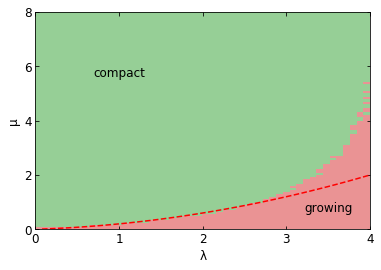

In [35]:
p = 0.1
image = np.load(f'chains/bound_{p}.npy')

plt.imshow(image.T, origin='lower', extent=(0,4,0,8), aspect='auto', cmap=cmap, norm=norm, alpha=0.5)
plt.plot(lam_array[p], p*lam_array[p] + p*lam_array[p]**2, 'r--')
plt.xticks(np.linspace(0,4,5))
plt.yticks(np.linspace(0,8,5))
plt.text(1,6,'compact', ha='center', va='top')
plt.text(3.5,1,'growing', ha='center', va='top')
plt.xlabel("λ")
plt.ylabel("μ")
plt.savefig("plots/6b.pdf")

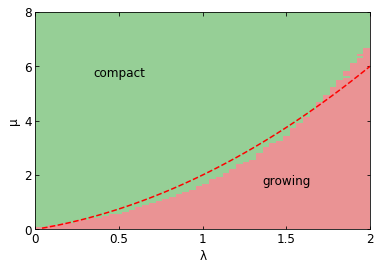

In [36]:
p = 1
image = np.load(f'chains/bound_{p}.npy')

plt.imshow(image.T, origin='lower', extent=(0,2,0,8), aspect='auto', cmap=cmap, norm=norm, alpha=0.5)
plt.plot(lam_array[p], p*lam_array[p] + p*lam_array[p]**2, 'r--')
plt.xticks(np.linspace(0,2,5), ['0', '0.5', '1', '1.5', '2'])
plt.yticks(np.linspace(0,8,5))
plt.text(0.5,6,'compact', ha='center', va='top')
plt.text(1.5,2,'growing', ha='center', va='top')
plt.xlabel("λ")
plt.ylabel("μ")
plt.savefig("plots/6a.pdf")